# install small text

In [1]:
%pip install small-text==1.3.0   

# additional dependencies for this example
# %pip install datasets matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import warnings
import logging
import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from small_text import SklearnDataset, PoolBasedActiveLearner, PredictionEntropy, SklearnClassifierFactory, random_initialization_balanced
import matplotlib.ticker as mtick

# Read Data

In [3]:
df = pd.read_csv("/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv" ,encoding='iso-8859-1')

In [4]:
df.head()

,polarity of tweet,id of the tweet,date of the tweet,query,user,text of the tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
[feature for feature in df.columns if df[feature].isnull().sum()>=1]

[]

In [6]:
# except polarity of tweet and text of the tweet all other are not important column to us for sentimental analysis
df.drop(columns=['id of the tweet' , 'date of the tweet' , 'query' , 'user'],inplace=True)

In [7]:
print(df.columns)
df.columns = df.columns.str.strip()

Index(['polarity of tweet ', 'text of the tweet '], dtype='object')


In [8]:
X = df['text of the tweet'].values
Y = df['polarity of tweet'].values

In [9]:
df['polarity of tweet'].value_counts()

polarity of tweet
0    799996
4    248576
Name: count, dtype: int64

In [10]:
# from sklearn.utils import resample

# # Undersampling
# # Downsample majority class to the size of the minority class
# df_majority = df[df['polarity of tweet'] == 0]
# df_minority = df[df['polarity of tweet'] == 4]
# df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_minority), random_state=42)
# df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [11]:
# X = df_downsampled['text of the tweet'].values
# Y = df_downsampled['polarity of tweet'].values

In [12]:
# import pandas as pd

# # Convert Y to a pandas Series
# Y_series = pd.Series(Y)

# # Get value counts
# value_counts = Y_series.value_counts()

# print(value_counts)

In [13]:
import numpy as np
len(np.unique(Y))

2

#  Split Data

In [14]:
# Create train and test datasets
train = {'text': X[:int(0.8*len(X))], 'label': Y[:int(0.8*len(Y))]}
test = {'text': X[int(0.8*len(X)):], 'label': Y[int(0.8*len(Y)):]}

In [15]:
train["label"][0]

0

# Vectorize Data

In [16]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))

In [17]:
num_classes = len(np.unique(Y))

## Create SklearnDataset instances


In [18]:
# # Create SklearnDataset instances
target_labels = np.arange(num_classes)

train = SklearnDataset.from_arrays(np.array(train['text']),np.array(train['label']),vectorizer=vectorizer,target_labels=np.unique(train['label']))

test = SklearnDataset.from_arrays(np.array(test['text']),np.array(test['label']),vectorizer=vectorizer,target_labels=np.unique(test['label']),train=False)

/opt/conda/lib/python3.10/site-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


In [19]:
# Initialize the logistic regression model
seed = 200
model = LogisticRegression(random_state=seed)

Test F1-score: 0.78
---------------
Iteration #0 (600 samples)
Test F1-score: 0.89
---------------
Iteration #1 (700 samples)
Test F1-score: 0.93
---------------
Iteration #2 (800 samples)
Test F1-score: 0.93
---------------
Iteration #3 (900 samples)
Test F1-score: 0.93
---------------
Iteration #4 (1000 samples)
Test F1-score: 0.93
---------------
Iteration #5 (1100 samples)
Test F1-score: 0.93
---------------
Iteration #6 (1200 samples)
Test F1-score: 0.93
---------------
Iteration #7 (1300 samples)
Test F1-score: 0.93
---------------
Iteration #8 (1400 samples)
Test F1-score: 0.93
---------------
Iteration #9 (1500 samples)
Test F1-score: 0.93


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


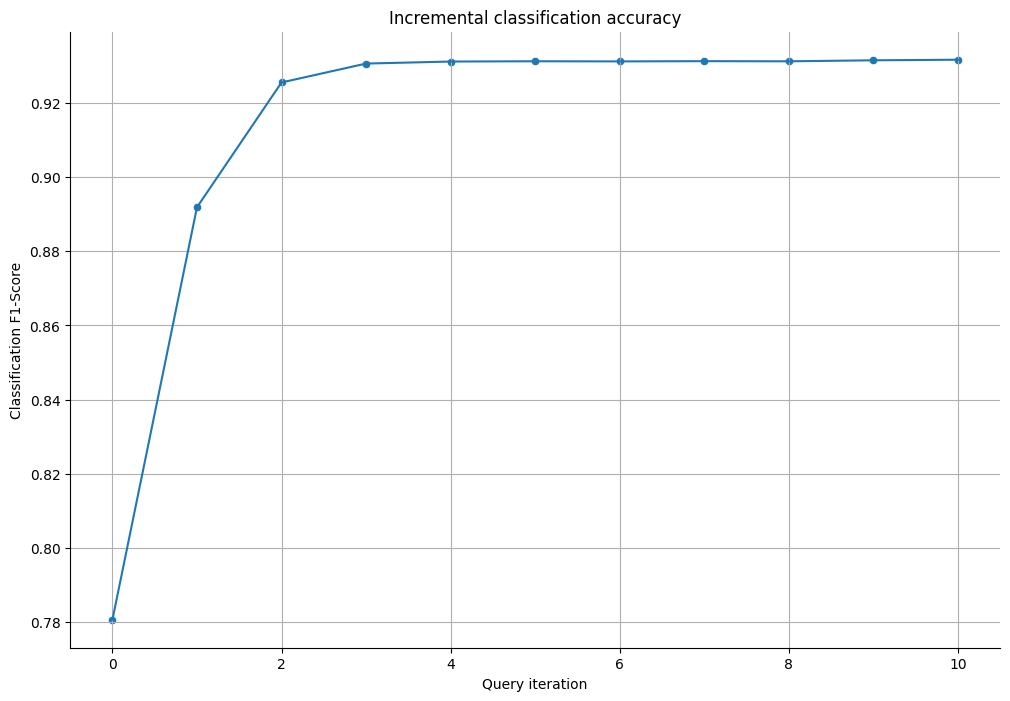

In [20]:
clf_factory = SklearnClassifierFactory(model, num_classes)

# Initialize the active learner with PredictionEntropy query strategy
query_strategy = PredictionEntropy()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)

# Function to initialize the active learner
def initialize_active_learner(active_learner, y_train):
    indices_initial = random_initialization_balanced(y_train, n_samples=500)
    active_learner.initialize_data(indices_initial, y_train[indices_initial])
    return indices_initial

# Initialize the active learner
indices_labeled = initialize_active_learner(active_learner, train.y)

# Define the evaluation function
def evaluate(active_learner, train, test):
    y_pred_train = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    train_f1 = f1_score(train.y, y_pred_train,average='weighted')
    test_f1 = f1_score(test.y, y_pred_test, average='weighted')

#     print('Train F1-score: {:.2f}'.format(train_f1))
    print('Test F1-score: {:.2f}'.format(test_f1))
    
    return test_f1

# Perform active learning iterations
num_queries = 10
results = []

results.append(evaluate(active_learner, train[indices_labeled], train))  # Using train set for initial evaluation

for i in range(num_queries):
    indices_queried = active_learner.query(num_samples=100)
    y = train.y[indices_queried]
    active_learner.update(y)
    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], train))

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=10, integer=True))
plt.grid()

data = np.vstack((np.arange(num_queries+1), np.array(results)))
sns.lineplot(x=0, y=1, data=data)
sns.scatterplot(x=0, y=1, data=data)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification F1-Score')
sns.despine()

plt.show()